In [1]:
#Explicit Finite-Difference diffusion model for Sr in Plagioclase
"""This version of the code is for Mount St. Helens 319-1 (July 2005 eruption) plagioclase grain 27. The data was
    collected from Dr. Richard Bradshaw for his dissertation work. Data from Chapter 5 supplimentary data. Modeling
    is done using the discretized diffusion equation reported in appendix one of Costa et al., 2008"""

%matplotlib inline
import pandas as pd # for reading the CSV file easily
from dateutil import parser # for parsing text-based dates
from numpy import * # for masking
import pylab as PP # for plotting
import matplotlib as mpl # import matplotlib
from scipy.optimize import curve_fit

#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)



In [2]:
#Uses Pandas(pd.) to read the excel file titled 'Sr_Diff_Model_Input.xls' and specifically sheet 'TE_Data' and set it to variable TEData
TEData = pd.read_excel(open('MSH_TE_Profiles_Bradshaw.xlsx','rb'), sheetname='MSH-319-1-Plag-27', parse_cols = "A, B, L, AB, S")

In [3]:
#TEData #Prints TEData variable imported in line 9


In [4]:
TEData_numpy=TEData.as_matrix() #converts TEData from panda series to a numpy array and assigns data to TEData_numpy


In [5]:
"""This block of code extracts the desired arrays from the numpy matrix created above and assigns them to variables
    Note: The code with the form Sr_array = Srdata[0:19] extracts a specific range in values from an array for example
    this code extracts the first through 19th value in the Srdata array and assigns only those values to the Sr_array 
    variable. This can be used to isolate a specific portion of the compositional profile that is targeted for the diffusion
    model."""

Srdata = TEData_numpy[:,1] #assigns all of column 1 (second column) from TEData_numpy to variable Srdata
Sr_array = Srdata[0:19] #This extracts only the first 19 values from the Srdata array to be used in the subsequent model

Sr_err = TEData_numpy[:,3] #assigns all of column 3 (fourth column) from TEData_numpy to variable Sr_err
Sr_SE = Sr_err[0:19] #This extracts only the first 19 values from the Sr_err array to be used in the subsequent model

An = TEData_numpy[:,2] #assigns all of column 3 (third column) from TEData_numpy to variable An
An_array = An[0:19] #This extracts only the first 19 values from the An array to be used in the subsequent model

Dist = TEData_numpy[:,0] #assigns all of column 0 (first column) from TEData_numpy to variable Dist
Dist_array = Dist[0:19] #This extracts only the first 19 values from the Dist array to be used in the subsequent model

Dist_rev = Dist[::-1] #This reverses the order of the distance array in case the core and rim are flipped (always want rim to core to be left to right)
Dist_inverse = Dist_rev[0:19] #This extracts only the first 19 values from the Dist_rev array to be used in the subsequent model

In [6]:
#PP.errorbar(Dist_array, Sr_array, yerr=Sr_SE, fmt='ro') #pyplot (PP) plots (x variable, y variable, changes symbol color and style) ro=red circle
#PP.title('TE profile') #changes chart title
#PP.xlabel('Distance [mircons]') #adds x axis label
#PP.ylabel('Sr [ppm]') #adds y axis label
#PP.show()

In [7]:
#Constant Variables
X_An = An_array
R = 8.31446 #gas constant in J/mol*K
ASr = -30400 #+/- 1100 J/mol constant in J/mol for Sr partitioning into plagioclase from Bindeman et al. (1998)
BSr = 28500 #+/- 700 J/mol constant in J/mol for Sr partitioning into plagioclasefrom Bindeman et al. (1998)

#Variable Variables
Tc = 750 #T in C
T = Tc + 273.15 #T in Kelvin
dt = 0.1*60*60*24*365 #timestep in seconds. (Note all these need to be in SI units). First term is T in years.
tfin = 1000*60*60*24*365 #final time in seconds. (Note all these need to be in SI units). First term is T in years.
dx = 5e-6 #delta x in m (Note all these need to be in SI units)


In [8]:
#This function fills missing values in a data array with a chosen average value.
""" This function fills in missing values (Nans) in the chosed data array and replaces them with a calculated 
    average value.
    Inputs: data_array = array with Nan values to be filled
            Values_to_ave = number of values to be averaged (average of these will replace Nan values)"""

def gap_fill(data_array, Values_to_ave): 
    Sorted_array = sort(data_array) #this sorts the input data array from low values to high
    Fill_Val = average(Sorted_array[0:Values_to_ave]) #Calculates the average from the first value in the sorted array (lowest value) to the values specified in the value_to_ave input (e.g. if you put in 5 in input it will calculate the average of the first 5 values in the sorted array).
    Mask_array = ma.masked_invalid(data_array) #Creates an array from the data_array that masked invalid (Nan) values
    Fill_array = ma.filled(Mask_array, Fill_Val) #Replaces the invalid values (Nan) with calculated average value
    
    return Fill_array #Returns the array with Nan's filled
    
X_An_Fill = gap_fill(X_An, 5)  #Creates filled X_An array.

Sr_fill = gap_fill(Sr_array, 5)   #Creates filled measured Sr array

Sr_SE_fill = gap_fill(Sr_SE, 5) #Creates filled measured Sr_error array

In [9]:
#Define Boundary conditions
Sr_core = Sr_fill[-1] #Assigns Sr measured at the core most point to the variable Sr_core
Sr_rim = Sr_fill[0] #Assigns Sr measured at the rim most point to the variable Sr_rim


In [10]:
#equilibrium profile
Sr_Kd_Bind = exp((ASr*X_An_Fill+BSr)/(R*T)) #Calculate the Sr partition coefficient for each point in the TE profile (from X_an)
Sr_liq = Sr_fill[0]/Sr_Kd_Bind[0] #Calculates liquid Sr concentration in equilibrium with the rim most point
Eq_prof = Sr_liq*Sr_Kd_Bind #Calculated the Sr TE profile in equilibrium with the calculated melt composition at crystal rim

#Calculating diffusivities of Sr in Plagioclase
D_Sr = (10**-(4.1*X_An_Fill+4.08))*(exp(-3.32*(10**4/T))) #calculates the diffusivity of Sr at each spot based on X_An using the equation from Zellmer et al. 2003
DSr_H = 2*D_Sr #Upper bound on Sr diffusivity based on statement in Zellmer (2003) The Sr diffusivity has uncertainty of a factor of ~2 based on 2 sigma uncertaintly of Giletti and Casserly (1994)   
DSr_L = 2/D_Sr #Lower bound of Sr diffusivity based on statement in Zellmer (2003) The Sr diffusivity has uncertainty of a factor of ~2 based on 2 sigma uncertaintly of Giletti and Casserly (1994)

In [11]:
#Defining initial conditions (This defines initial conditions as a step function)
""" This function generates a step function that can be used as the intital condition
    
    Inputs x = array of x-values (distance array of compositional profile)
            step_location = location on x-axis to place the actual step in the function
            left_val = specify the value of step function to the left of the step
            right_val = specify the value of step function to the right of the step"""

def step_function(x,step_location,left_val,right_val): #defines step function function which for input variables
    step_func = left_val*ones(shape(x)) #Creates a step_func array that is filled with left_val values and the length of the x array specified above 
    igreater = where(x > step_location) #Where the x array is greater then the step_location value assign x values to igreater
    step_func[igreater] = right_val #Where x array is greatter then step_location (igreater values) assign right_val value
    return step_func #Return completed step function array

#curve_fit routine to optimize the step function fit for the initial condition

#PP.errorbar(Dist_array, Sr_array, yerr=Sr_SE, fmt='ro') #pyplot (PP) plots (x variable, y variable, changes symbol color and style) ro=red circle
#PP.plot(Dist_array, step_function(Dist_array, 32.5, 790, 1260))
#PP.title('TE profile') #changes chart title
#PP.xlabel('Distance [mircons]') #adds x axis label
#PP.ylabel('Sr [ppm]') #adds y axis label
#PP.show()

In [12]:
#PP.errorbar(Dist_array, Sr_fill, yerr=Sr_SE_fill, fmt='ro', label = 'Measured Prof.') #pyplot (PP) plots (x variable, y variable, changes symbol color and style) ro=red circle
#PP.plot(Dist_array, step_function(Dist_array, 32.5, 790, 1260), 'k--', label = 'Initial Cond.')
#PP.plot(Dist_array, Eq_prof, 'b^', label = 'Equil. Prof.') #plots the equilibrium profile calculated above as blue triangles
#PP.title('TE profile') #changes chart title
#PP.xlabel('Distance [mircons]') #adds x axis label
#PP.ylabel('Sr [ppm]') #adds y axis label
#PP.legend(loc = 'best')
#PP.savefig('Diff_prof_test.jpg')
#PP.show()

In [13]:
#Define Delta function (the delta function is dependent on the approach you choose to use (forward vs. centered))
#Delta function for forward approach
"""These function allow you to do the first and second derivative of an array to be used in derivative func below
    Inputs: x = array on which to perform the derivative
            i = the specific value within the array to perform the array on"""

def Delta1(x,i): #This defines the delta function for term 1 (first derivative) of the discretized equation
    return x[i+1]-x[i] #returns first derivative

def Delta2(x,i): #This defines the delta function for term 2 (second derivative) of the discretized equation
    return x[i+1]-2*x[i]+x[i-1] #returns second derivative


In [14]:
"""This function calculats the first derivative of the input array at each point dx
    Inputs: input_array = array on which to perform the first derivative
            dx = distance step in x dimension (specified above)"""

def first_der(input_array, dx): #calculates first derivative of the input array using the spacing specified by dx  
    
    First_Der = zeros(len(input_array))          #creates a first derivative array of length input_array that will be amended with the for loop
    for i in range(0, len(input_array)-1):       #for each element in the input array from the first element to the second to last element execute the following code
        First_Der[i] = Delta1(input_array, i)/dx #for each point on input array using a distance of dx apply to delta1 fuction (calculate the first derivative)
    
    First_Der[-1] = First_Der[-2] #Tells last calculated derivative to be equal to the second to last calculation to account for boundary conditons
    
    return First_Der #Returns results of first derivative function in a way that can be referred to and used in subsequently written code



def sec_der(input_array, dx): #calculates second derivative of the input array using the spacing specified by dx
    
    Sec_Der = zeros(len(input_array))               #creates a second derivative array of length input_array that will be amended with the for loop
    for i in range(1, len(input_array)-1):          #for each element in the input array from the first element to the second to last element execute the following code
        Sec_Der[i] = Delta2(input_array, i)/(dx**2) #for each point on input array using a distance of dx apply to delta2 fuction (calculate the second derivative)
    
    Sec_Der[-1] = Sec_Der[-2] #Tells last calculated derivative to be equal to the second to last calculation to account for boundary conditons
    Sec_Der[0] = Sec_Der[1] #Makes the second derivative of the first point of an array equal the second derivative of the second point to acound for boundary conditions
    
    return Sec_Der #Returns results of second derivative function in a way that can be referred to and used in subsequently written code


In [15]:
#Apply derivative functions to arrays used in the discrete diffusion equation
#First derivative fuction needs to be applied to the concentration profile (initial condition) and diffusivity array
#Second derivative function needs to be applied only to concenctration profile (initial condition)

Initial_prof = step_function(Dist_array, 32.5, 790, 1260) #This is the diffusion profile (initial profile) that will evolve with time steps

#D_Sr_firder = first_der(D_Sr, dx) #perfoms first derivative function on the Sr diffusion coefficient array
#Diff_prof_firder = first_der(Init_prof, dx) #perfoms first derivative function on the intial diffusion profile array (step function)

#Diff_prof_secder = sec_der(Init_prof, dx) #perfoms second derivative function on the initial diffusion profile array (step function)


In [16]:
"""This function applies the discretized diffusion equation to the data arrays specified for one time step
    Inputs: Init_prof = initial concentration profile (step function or initial condition)
            D_Sr = Array of calculated diffusivities for Sr in plagioclase
            dt = Time step in seconds
            left_bound = left boundary condition
            right_bound = right boundary condition
            *Note: the None values in the left and right bound values make it so that if you do not input
            values for these arguments the function will not impliment the if statements below"""

def step_forward(Init_prof, D_Sr, An_prof, dt, left_bound = None, right_bound = None):
    
    #First derivative
    D_Sr_firder = first_der(D_Sr, dx)           #perfoms first derivative function on the Sr diffusion coefficient array
    Diff_prof_firder = first_der(Init_prof, dx) #perfoms first derivative function on the intial diffusion profile array (step function)
    An_firder = first_der(An_prof, dx)
    
    #Second derivative
    Diff_prof_secder = sec_der(Init_prof, dx)   #perfoms second derivative function on the initial diffusion profile array (step function)
    An_secder = sec_der(An_prof, dx)
    
    #Discrete diffusion equation
    New_prof = (Init_prof + dt*(D_Sr_firder*Diff_prof_firder + D_Sr*Diff_prof_secder)) - ASr/R*T *((D_Sr*Diff_prof_firder*An_firder) + (Init_prof*(D_Sr_firder*An_firder)) + (D_Sr*Init_prof*(An_secder)))#comibines calculations above into discrete diffusion equation and calculates new profile after 1 specified timestep.
    
    if left_bound is not None: #If a left bound is specified in the arguments above then this will pin the left (rim) most point in the model profile to the specified left_bound value. If no left_bound argument is speficied the model is not pinned
        New_prof[0] = left_bound 
        
    if right_bound is not None: #If a right bound is specified in the arguments above then this will pin the right (core) most point in the model profile to the specified right_bound value. If no right_bound argument is speficied the model is not pinned
        New_prof[-1] = right_bound
        
    return New_prof #returns new calculated profile


In [17]:
"""Chi-square function calculated the chi-square value for the fit between the measured and modeled profile
    Inputs: Meas_prof = Measured profile
            Model_prof = Modeled profile"""

def Chi_square(Meas_prof, Model_prof):
    Chi_square = sum((Meas_prof - Model_prof)**2/Model_prof) #Calculates Chi-square
    return Chi_square



In [18]:
"""Performes the above step forward function for a specified amount of time at a given time step
    Inputs: Comp_prof = measured profile (Sr concentration profile)
            Init_cond = Initial condition or inferred initial condition prior to diffusion occuring
            Distance = Distance array
            
    For Loop inputs:
            0 = intital time is 0 after no diffusion
            tfin = final time in seconds (e.g. how long model runs for(specified above))
            dt = time step in seconds (specified above)"""


def diff_model(comp_prof, Init_cond, Distance):

    Initial_prof = step_function(Dist_array, 32.5, 790, 1260) #This is the diffusion profile (initial profile) that will evolve with time steps

    Run_time = arange(0, tfin, dt) #Creates a model time vector from time 0 to time final at a spacing of dt
    Run_time_yrs = Run_time/3600/24/365 #converts run time vector from seconds to years
    Model_profiles = []  #creates an empty list that is appended with each successive calculated model profile
    Chi_square_vals = [] #creates an empty list which is appended with the chi-square values calculated in the loop below


    for i in arange(0, tfin, dt):
        Model_prof = step_forward(Init_cond, D_Sr, X_An_Fill, dt, Initial_prof[0]) #Runs step forward function for each timestep in full range of time and outputs the model profile.
        Init_cond = Model_prof #Makes diffusion profile = the modeled profile at each successive time step (makes inital profile for each time step the calculated profile from the previous time step) 
        Model_profiles.append(Model_prof) #appends model_profiles list above with each successive calculated model profile
        fit = Chi_square(comp_prof, Model_prof) #Calculates the chi-square value between the measured Sr profile and modeled profile
        Chi_square_vals.append(fit) #Appends the Chi_square_vals list with the chi-square value at each time step


    Chi_min_index = argmin(Chi_square_vals) #finds the index in the Chi_square_vals array with the lowest value (this is the lowest chi-square value and thus the best fit index)
    Chi_min = Chi_square_vals[Chi_min_index] #Find corresponding Chi-square value to the Chi_min_index
    Run_time_best_fit = Run_time_yrs[Chi_min_index] #Find corresponding Run_time_best_fit to the Chi_min_index
    Best_fit_prof = Model_profiles[Chi_min_index] #Find corresponding Best_fit_prof to the Chi_min_index
    final_prof = Model_profiles[-1] #Extracts the final diffusion profile from the stored model profiles array
    
    return Chi_min, Run_time_best_fit, Best_fit_prof, Run_time_yrs, Chi_square_vals, final_prof #outputs the variable of interest

Chi_min, Run_time_best_fit, Best_fit_prof, Run_time_yrs, Chi_square_vals, final_prof = diff_model(Sr_fill, Initial_prof, Dist_array) #Runs the diffusion model on the compositional profile and the initial condition and outputs variable of interest to specific values that can subsequently be plotted and manipulated.

In [19]:
"""This function generates a random compositional profile within the 1 SE of the measured compositional profile
    Inputs: Comp_profile = the measured compositional profile array
            Error = the standard error array for the measured profile"""

def Err_profile_generator(Comp_profile, error):
    
    random_error = zeros(len(Comp_profile))  #creates an array of zeros the length of the input compositional profile
    
    for i in range(len(Comp_profile)):  #tells the function to apply the following code to every element (i) in the compositional profile array 
        random_error[i] = random.normal(loc=0, scale=error, size=None)[0] #generates a random value within a normal distribution width equal to the standard error at each point and appends it to the random_error array
    
    noisy_array = Comp_profile + random_error #adds the random error to the input composition profile
    
    return noisy_array #output this nes noisy array


In [20]:
"""Does a monte carlo approach to incorporating the analytical uncertainty in the measured composition profile of a
    given plagioclase crystal. Essentially generates a series of possible composition profiles that fit within the 
    measured SE of the composition profile and applies the diffusion model to each of those to determine the best fit
    time for a series of possible composition profiles. It then appends each of these time to arrays that can be 
    manipulated later."""


Chi_min_error = [] #creates and empty array with the variable Chi_min_err, which is calculate chi-square values of the diffusion model applied to the generated error profiles.
Run_time_best_fit_error =[] #Same as above, but with Run_time_best_fit
Best_fit_prof_error = [] #Same as above, but with Best_fit_prof
Run_time_yrs_error = [] #Same as above, but with Run_time_yrs
Chi_square_vals_error = [] #Same as above, but with Chi_square_vals
final_profs_error = []


for i in range(100): #This loop applies the diffusion model to a series of generated profiles that fit within error of the analytical uncertaintly the number in the () is the number of error profiles the loop will generate and fit with the diffusion model.
    Err_prof = Err_profile_generator(Sr_fill, Sr_SE_fill) #generates error profile using the Err_profile_generator function
    Chi_min_err, Run_time_best_fit_err, Best_fit_prof_err, Run_time_yrs_err, Chi_square_vals_err, final_prof_err = diff_model(Err_prof, Initial_prof, Dist_array) #applied diffusion model function to generated error profiles and outputs variable of interest
    Chi_min_error.append(Chi_min_err) #appends above empty Chi_min_err array with output value from diffuion model
    Run_time_best_fit_error.append(Run_time_best_fit_err) #Same as above, but with Run_time_best_fit
    Best_fit_prof_error.append(Best_fit_prof_err) #Same as above, but with Best_fit_prof
    Run_time_yrs_error.append(Run_time_yrs_err) #Same as above, but with Run_time_yrs
    Chi_square_vals_error.append(Chi_square_vals_err) #Same as above, but with Chi_square_vals
    final_profs_error.append(final_prof_err) #Same as above, but with final profiles.


Min_time = amin(Run_time_best_fit_error) #Finds the minimum best fit run time generated by the monte carlo simulation above
Max_time = amax(Run_time_best_fit_error) #Finds the maximum best fit run time generated by the monte carlo simulation above
p5, p95 = percentile(Run_time_best_fit_error,[5,95]) #This finds the 5th and 95th percentile value of the Run_time_best_fit_err array   

#print Min_time, Max_time #outputs the minimum and maximum best fit run times from the monte carlo simulation above (essentially gives a range of best fit run times that are within analytical uncertaintly of the measured composition profile)
#print p5,p95

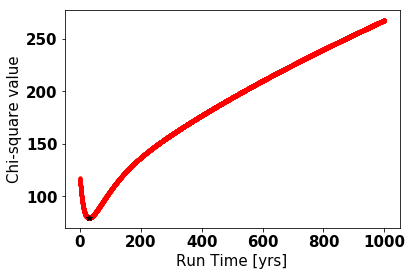

In [21]:
#Plots 
PP.errorbar(Dist_array, Sr_fill, yerr=Sr_SE_fill, fmt='ro', label = 'Measured Prof.') #pyplot (PP) plots (x variable, y variable, changes symbol color and style) ro=red circle
PP.plot(Dist_array, step_function(Dist_array, 32.5, 790, 1260), 'k--', label = 'Initial Cond.')
PP.plot(Dist_array, Eq_prof, 'b^', label = 'Equil. Prof.') #plots the equilibrium profile calculated above as blue triangles
PP.plot(Dist_array, Best_fit_prof, 'g-',linewidth=2, label = 'Best Fit Prof.')
#PP.plot(Dist_array, final_prof, 'k-', linewidth=2)
#PP.title('TE profile') #changes chart title
PP.xlabel('Distance [mircons]') #adds x axis label
PP.ylabel('Sr [ppm]') #adds y axis label
PP.text(38, 900, '$\chi^2$ = {:0.2f}'.format(Chi_min))
PP.text(38, 1000, 'Range = {:0.1f}-{:0.1f} yrs'.format(p5, p95))
PP.text(38, 1100, 'Best Fit Time = {:0.1f} yrs'.format(Run_time_best_fit))
#PP.legend(loc = 'best')
PP.savefig('Diff_fig_test.jpg')
PP.show()

#plots chi_square value vs. Run time in years and plots the minimum chi_square value as a black star
PP.plot(Run_time_yrs, Chi_square_vals, 'r.')
PP.plot(Run_time_best_fit, Chi_min, 'k*')
PP.xlabel('Run Time [yrs]')
PP.ylabel('Chi-square value')
PP.show()
